In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point, box

from shutil import rmtree
import os

from experiments.utils import set_plt_template
set_plt_template()

# Tutorial

This tutorial document serves the purpose of explaining components of the code and how to setup experiments. 

Essentially it will be updated alongside the packge during the thesis project.

As I don't have the time to write proper unit tests, this document serves as a sanity checker for myself.
Also I tend to validate newly implement features like parameterizations within experiment notebooks to ensure 
these work as expected.

Each TO problem *for now* consists of three main components:
- **Topology**: a data-container for describing the geometrical features of the design.
- **Parameterization**: a way for going from some design vector to a geometry.
- **Model**: the physics simulation.

A design vector is optimized using an *Optimizer* that produces some geometry through the **Parameterization**.
This **Parameterization** updates the **Topology** which then is passed to the physics **Model**. 
The physics **Model** then simulates the design of the new **Topology** and an *Objective* is calculated.

I think the following components should be added:
- *Optimizer*: for now only CMA-ES is used and is hard-coded.
- *Objective*: for now the compliance is calculated but is hard-coded.
- *Constraints*: like the objective.

<br>

> **General Programming Note** 
> 
> The package is designed in such a way that everything tends to be build out of a couple components which then must be build by the user themselves. Starting an experiment requires constructing some components which then are assembled in a centralized component, like TO.ProblemInstance. 
>
> Besides some TO.utils functions, for analyzing experiments, in the core I maintain a zero default parameter policy. This means there are no hidden variables which might affect experiments, all the components that build up an experiment control all underlying procedures.

## Topology

- **Topology**: a data-container for describing the geometrical features of the design.

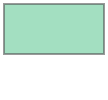

In [8]:
from TO.core import Topology

topology = Topology(
    continuous=True,
    domain=box(0, 0, 100, 50), 
    density=1
)

topology.domain

The **continuous** attribute tells the parameterization method wether to generate a geometry based on the underlying continuous representation of the geometry or by using the rasterized version which corresponds directly to the mesh of the physics model. 

You will see an example below when we generate some geometry with a parameterization. Geometry can be used for calculating constraints, for example if the design is connected to the edge of the domain. A continuous geometry gives you the exact distance based on the underlying representation while the discrete geometry gives the distance which corresponds to the geometry in the discretized mesh.

The **density** parameter controls the element size of the (square) mesh elements, i.e. a density of 0.5 corresponds to quads of size: (2x2) in the same units of the **domain**.

## Parameterization

- **Parameterization**: a way for going from some design vector to a geometry.

In [9]:
from TO.parameterizations.mmc import Capsules, MMCEndpointsConfig, StraightBeam

parameterization = Capsules(
    topology,
    representation=MMCEndpointsConfig,
    symmetry_x=False, 
    symmetry_y=True, 
    n_components=1,
    deformer=StraightBeam,
    n_samples=100,
)

parameterization.dimension

5

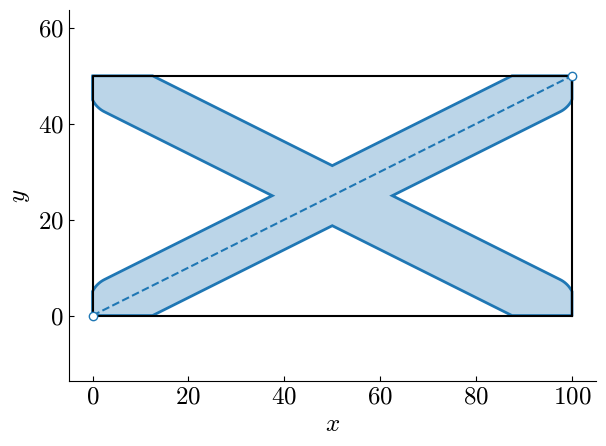

In [10]:
x = np.zeros(parameterization.dimension).reshape(-1, parameterization.dimension_per_mmc)
x[0] = (0, 0, 1, 1, 0.1)

parameterization.update_topology(topology, x)
topology.plot(); 

plt.plot([0,topology.domain_size_x], [0,topology.domain_size_y], 'C0o--', mfc='w'); plt.xlabel('$x$'); plt.ylabel('$y$'); plt.axis('equal'); plt.tight_layout()

When building the geometry (updating the *Topology*) with the *Parameterization* using a new desgin vector $\mathbf{x}$, the *Parameterization* automatically intersects the 
geometry with the problem domain: Topology.domain.

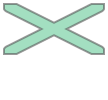

In [11]:
topology.geometry

relative area  : 0.438
distance to pt : 16.759


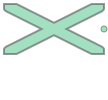

In [12]:
pt = Point(topology.domain_size_x, topology.domain_size_y/2)

print(f'relative area  : {topology.geometry.area / topology.domain.area:.3f}')
print(f'distance to pt : {topology.geometry.distance(pt):.3f}')

topology.geometry.union(pt)

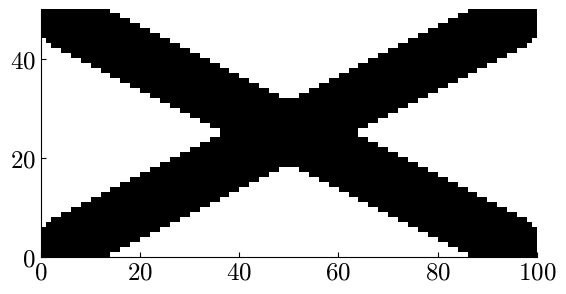

In [13]:
plt.imshow(topology.mask, extent=(0, topology.domain_size_x, 0, topology.domain_size_y), cmap='binary');

relative area  : 0.452
distance to pt : 16.125


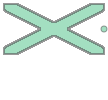

In [14]:
topology.continuous = False
parameterization.update_topology(topology, x)

print(f'relative area  : {topology.geometry.area / topology.domain.area:.3f}')
print(f'distance to pt : {topology.geometry.distance(pt):.3f}')

topology.geometry.union(pt)

In [16]:
from TO.core import run_experiment
from TO.problems.beam import create_horizontal_cantilever_problem

topology.continuous = True
problem = create_horizontal_cantilever_problem(topology, parameterization)
run_experiment(problem, budget=100, sigma0=0.25, seed=1, name='tutorial')

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 5 (seed=1, Tue Apr 22 09:03:14 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 5.857496698603797e+04 1.0e+00 2.41e-01  2e-01  3e-01 0:00.0
    2     16 6.289997509828745e+04 1.3e+00 2.55e-01  2e-01  3e-01 0:00.0
    3     24 5.014946322043230e+04 1.8e+00 2.33e-01  2e-01  3e-01 0:00.0
   32    256 8.785131208723419e-02 4.1e+00 4.54e-02  2e-02  5e-02 0:03.7
   40    320 8.837792513966666e-02 3.9e+00 2.64e-02  8e-03  2e-02 0:08.2


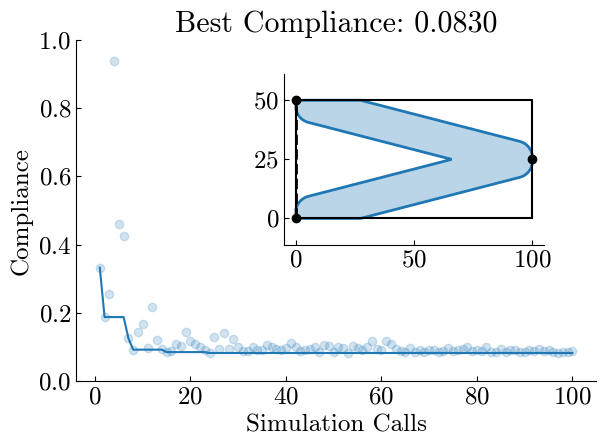

In [17]:
fig, ax = plt.subplots()
ins = ax.inset_axes([0.4,0.4,0.5,0.5])

ax.plot(np.arange(problem.budget)+1, np.minimum.accumulate(problem.scores))
ax.plot(np.arange(problem.budget)+1, problem.scores, 'C0o', alpha=.2)
ax.set_ylim(0, 1); ax.set_xlabel('Simulation Calls'); ax.set_ylabel('Compliance'); ax.set_title(f'Best Compliance: {problem.score_best:.4f}')

problem.plot_best(ins)
fig.tight_layout()

Regular beams
4 beams (w/symmetry) 5d/mmc -> 10d
8 beams (w/symmetry) 5d/mmc -> 20d
20 beams (w/symmetry) 5d/mmc -> 50d
40 beams (w/symmetry) 5d/mmc -> 100d
80 beams (w/symmetry) 5d/mmc -> 200d

Guo
2 beams (w/symmetry) 5d/mmc -> 10d
4 beams (w/symmetry) 5d/mmc -> 20d
10 beams (w/symmetry) 5d/mmc -> 50d
20 beams (w/symmetry) 5d/mmc -> 100d
40 beams (w/symmetry) 5d/mmc -> 200d

budget = 100*d

figure out when to graduate, "last day of july" ~Elena

## Deformation

In [18]:
from TO.parameterizations.mmc import QuadraticBezierDeformer

parameterization = Capsules(topology, False, False, 1, MMCEndpointsConfig, QuadraticBezierDeformer(1000), 1000)

parameterization.dimension

7

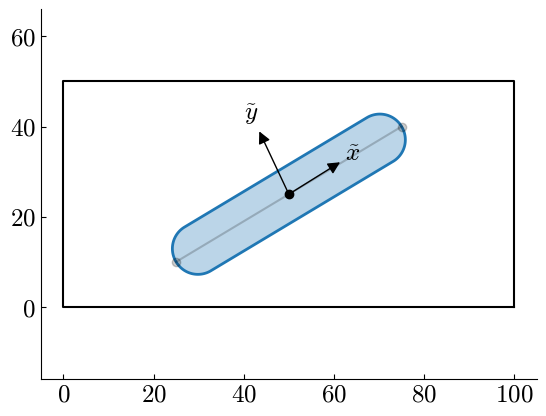

In [19]:
x_mmc = [0.25, 0.2, 0.75, 0.8, 0.1] # (x1, y1, x2, y2, r)
x_deformation = [0.5, 0.5]

parameterization.update_topology(topology, np.r_[x_mmc, x_deformation])
topology.plot()

endpoints = parameterization.scale(np.r_[x_mmc, x_deformation])[:4].reshape(2, 2)
t = endpoints[1] - endpoints[0]

plt.annotate(r'$\tilde{x}$', endpoints.mean(axis=0), endpoints.mean(axis=0) + t/4, arrowprops={'arrowstyle': '<|-', 'color': 'k'})
plt.annotate(r'$\tilde{y}$', endpoints.mean(axis=0), endpoints.mean(axis=0) + np.array([-t[1], t[0]])/3, arrowprops={'arrowstyle': '<|-', 'color': 'k'})
plt.plot(*endpoints.mean(axis=0), 'ko')
plt.plot(*endpoints.T, 'ko-', alpha=.2)

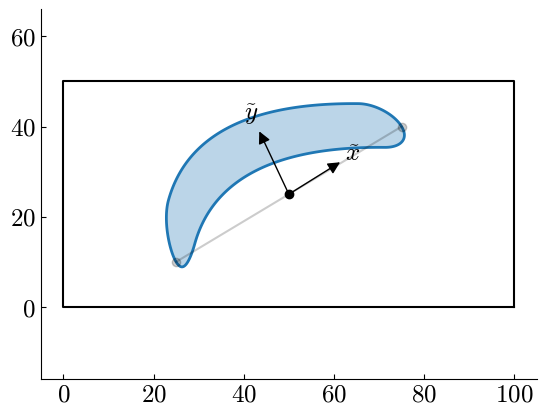

In [20]:
x_deformation = [0.3, 1]

parameterization.update_topology(topology, np.r_[x_mmc, x_deformation])
topology.plot()


plt.annotate(r'$\tilde{x}$', endpoints.mean(axis=0), endpoints.mean(axis=0) + t/4, arrowprops={'arrowstyle': '<|-', 'color': 'k'})
plt.annotate(r'$\tilde{y}$', endpoints.mean(axis=0), endpoints.mean(axis=0) + np.array([-t[1], t[0]])/3, arrowprops={'arrowstyle': '<|-', 'color': 'k'})
plt.plot(*endpoints.mean(axis=0), 'ko')
plt.plot(*endpoints.T, 'ko-', alpha=.2)

In [21]:
from TO.parameterizations.mmc import HarmonicDeformer

parameterization = Capsules(topology, False, True, 3, MMCEndpointsConfig, HarmonicDeformer(order=1, n_samples=1000), 1000)

problem = create_horizontal_cantilever_problem(topology, parameterization)
run_experiment(problem, budget=500, sigma0=0.25, seed=1, name='tutorial')

(6_w,12)-aCMA-ES (mu_w=3.7,w_1=40%) in dimension 18 (seed=1, Tue Apr 22 09:03:39 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     12 3.510500131256856e+04 1.0e+00 2.35e-01  2e-01  2e-01 0:00.1
    2     24 4.384448148465851e+04 1.1e+00 2.23e-01  2e-01  2e-01 0:00.2
    3     36 2.237089482816273e+04 1.2e+00 2.12e-01  2e-01  2e-01 0:00.3
   38    456 1.077391588693509e+04 2.1e+00 2.57e-01  2e-01  3e-01 0:03.4
   71    852 9.651028540241115e+03 3.0e+00 2.24e-01  1e-01  3e-01 0:07.4
  100   1200 4.632174176258509e+03 3.7e+00 2.12e-01  1e-01  3e-01 0:11.5
  158   1896 7.401738848353426e+02 4.0e+00 7.35e-02  4e-02  9e-02 0:17.6
  182   2184 2.119324303452903e-01 3.9e+00 5.62e-02  2e-02  7e-02 0:25.0
  196   2352 1.144892657241583e-01 4.3e+00 3.81e-02  1e-02  4e-02 0:33.4
  200   2400 1.027954628180498e-01 4.6e+00 4.18e-02  1e-02  5e-02 0:36.8
  213   2556 9.044656101761345e-02 5.8e+00 3.86e-02  1e-02  5e-02 0:47.3
  228   2736 8.124594899724767e-02 6.9

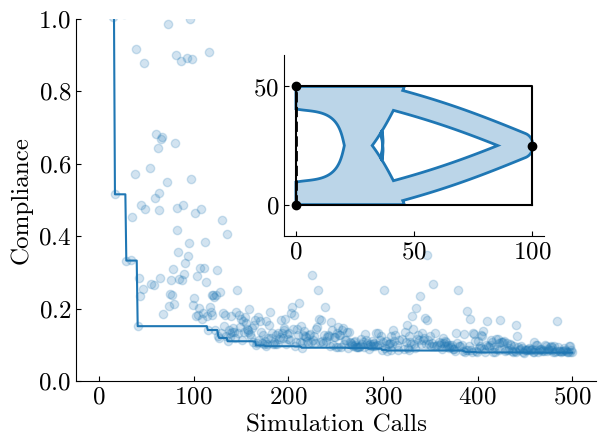

In [22]:
fig, ax = plt.subplots()
ins = ax.inset_axes([0.4,0.4,0.5,0.5])

ax.plot(np.arange(problem.budget)+1, np.minimum.accumulate(problem.scores))
ax.plot(np.arange(problem.budget)+1, problem.scores, 'C0o', alpha=.2)
ax.set_ylim(0, 1); ax.set_xlabel('Simulation Calls'); ax.set_ylabel('Compliance')

problem.plot_best(ins)
fig.tight_layout()

# Tilings

In [24]:
from TO.parameterizations.cell import BinaryCells, HexGrid, unit_hexagon

n_cells_y=3
parameterization_hex = BinaryCells(
    topology,
    sampler=HexGrid(horizontal=False),
    unit_cell=unit_hexagon(),
    cell_size_x=2/np.sqrt(3)*(topology.domain_size_y/2)/(n_cells_y-1/2),
    cell_size_y=2/np.sqrt(3)*(topology.domain_size_y/2)/(n_cells_y-1/2),
    symmetry_x=False,
    symmetry_y=True
)

In [25]:
parameterization_hex.dimension

36

In [26]:
problem = create_horizontal_cantilever_problem(topology, parameterization_hex)
run_experiment(problem, budget=500, sigma0=0.25, seed=1, name='tutorial')

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 36 (seed=1, Tue Apr 22 09:07:02 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 2.523525231727094e+04 1.0e+00 2.33e-01  2e-01  2e-01 0:00.0
    2     28 2.825946684486256e+04 1.1e+00 2.22e-01  2e-01  2e-01 0:00.1
    3     42 1.726055338212146e+04 1.1e+00 2.18e-01  2e-01  2e-01 0:00.1
   40    560 3.845315127366792e-01 1.4e+00 1.59e-01  2e-01  2e-01 0:03.2
   47    658 3.902811036224131e-01 1.4e+00 1.37e-01  1e-01  1e-01 0:07.9
   53    742 2.886811667253404e-01 1.5e+00 1.33e-01  1e-01  1e-01 0:13.0
   62    868 2.886811667253404e-01 1.6e+00 1.36e-01  1e-01  1e-01 0:19.7
   71    994 2.886811667253404e-01 1.6e+00 1.14e-01  1e-01  1e-01 0:26.7
   79   1106 2.886811667253404e-01 1.6e+00 1.12e-01  1e-01  1e-01 0:35.9
   89   1246 2.886811667253404e-01 1.7e+00 1.06e-01  1e-01  1e-01 0:45.8
   93   1302 2.886811667253404e-01 1.7e+00 9.74e-02  9e-02  1e-01 0:49.8
termination on tolflatfitness=1 (Tue A

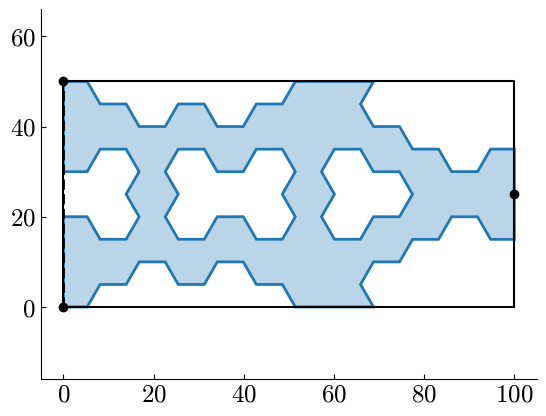

In [27]:
problem.plot_best()

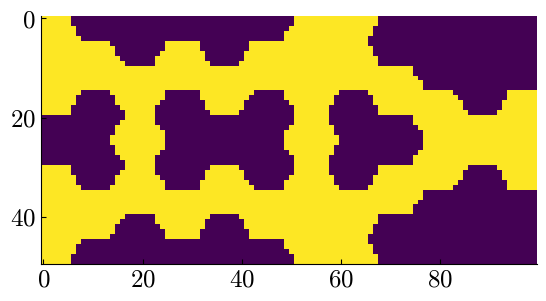

In [28]:
plt.imshow(topology.mask)

In [29]:
from TO.parameterizations.cell import infill, unit_circle, unit_square, RectangularGrid
from shapely.affinity import scale

topology.continuous = True

n_cells_x=10
parameterization = BinaryCells(
    topology,
    sampler=HexGrid(horizontal=False),
    unit_cell=infill(unit_hexagon(), 0.5),
    cell_size_x=2/np.sqrt(3)*(topology.domain_size_x)/(n_cells_x-1/2),
    cell_size_y=2/np.sqrt(3)*(topology.domain_size_x)/(n_cells_x-1/2),
    symmetry_x=False,
    symmetry_y=True
)

problem = create_horizontal_cantilever_problem(topology, parameterization)
run_experiment(problem, budget=500, sigma0=0.25, seed=1, name='tutorial')

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 33 (seed=1, Tue Apr 22 09:08:10 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 6.057393907843981e+03 1.0e+00 2.35e-01  2e-01  2e-01 0:00.0
    2     28 6.057393907843981e+03 1.1e+00 2.28e-01  2e-01  2e-01 0:00.1
    3     42 1.073462581635780e+00 1.1e+00 2.22e-01  2e-01  2e-01 0:00.5
   11    154 3.626688516350390e-01 1.3e+00 2.49e-01  2e-01  3e-01 0:03.5
   19    266 5.120886041471433e-01 1.4e+00 2.69e-01  3e-01  3e-01 0:07.6
   27    378 2.213572422931357e-01 1.5e+00 2.44e-01  2e-01  3e-01 0:12.8
   37    518 2.315543041673782e-01 1.5e+00 2.39e-01  2e-01  3e-01 0:18.8
   50    700 2.363293763026180e-01 1.6e+00 1.97e-01  2e-01  2e-01 0:26.0
   65    910 2.222069839046240e-01 1.7e+00 1.66e-01  2e-01  2e-01 0:34.7
   75   1050 2.199433395079554e-01 1.7e+00 1.52e-01  1e-01  2e-01 0:44.2


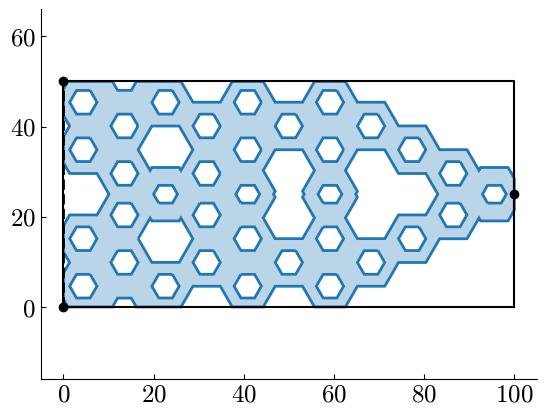

In [30]:
problem.plot_best()

In [31]:
from TO.parameterizations.cell import InfillCells, unit_circle, RectangularGrid, unit_square

topology.continuous = True
n_cells_y=2
parameterization_hex_infill = InfillCells(
    topology,
    sampler=HexGrid(horizontal=False),
    unit_cell=unit_circle(n_samples=100),
    cell_size_x=2/np.sqrt(3)*(topology.domain_size_y/2)/(n_cells_y-1/2),
    cell_size_y=2/np.sqrt(3)*(topology.domain_size_y/2)/(n_cells_y-1/2),
    symmetry_x=False,
    symmetry_y=True
)

problem = create_horizontal_cantilever_problem(topology, parameterization_hex_infill)
run_experiment(problem, budget=500, sigma0=0.25, seed=1, name='tutorial')

(5_w,11)-aCMA-ES (mu_w=3.4,w_1=42%) in dimension 14 (seed=1, Tue Apr 22 09:09:20 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     11 1.677032611315793e+00 1.0e+00 2.26e-01  2e-01  2e-01 0:00.3
    2     22 1.704968112914062e+00 1.1e+00 2.13e-01  2e-01  2e-01 0:00.6
    3     33 5.000963737237042e+00 1.2e+00 2.08e-01  2e-01  2e-01 0:01.1
   11    121 7.047990028325797e-01 1.6e+00 2.17e-01  2e-01  2e-01 0:04.2
   23    253 1.674839287066801e+00 1.8e+00 1.78e-01  1e-01  2e-01 0:08.4
   35    385 7.176603329097412e-01 2.1e+00 1.47e-01  1e-01  2e-01 0:13.5
   44    484 4.033022708571021e-01 2.1e+00 1.01e-01  8e-02  1e-01 0:20.0
   52    572 3.090833607525261e-01 2.4e+00 7.72e-02  5e-02  9e-02 0:27.1
   62    682 2.085624003204469e-01 2.7e+00 5.69e-02  4e-02  7e-02 0:35.3
   74    814 1.976438028300244e-01 3.3e+00 4.91e-02  3e-02  6e-02 0:44.6
   85    935 1.749132914293507e-01 4.0e+00 5.30e-02  3e-02  6e-02 0:54.9


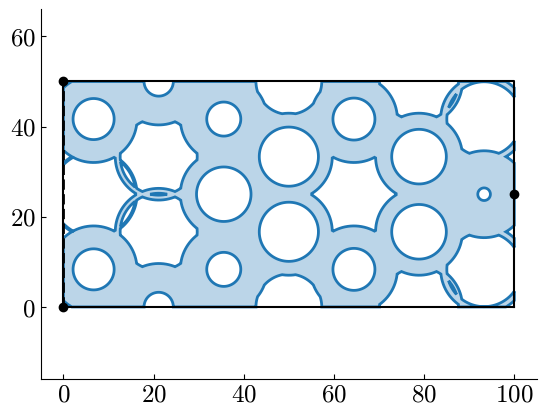

In [32]:
problem.plot_best()

In [33]:
from TO.parameterizations.cell import TriGrid, unit_triangle

parameterization = BinaryCells(
    topology,
    False,
    True,
    TriGrid(horizontal=False),
    scale(unit_triangle(), 1.2, 1.2),
    5,
    5
)

problem = create_horizontal_cantilever_problem(topology, parameterization)
run_experiment(problem, budget=500, sigma0=0.25, seed=1, name='tutorial')

(10_w,20)-aCMA-ES (mu_w=5.9,w_1=27%) in dimension 220 (seed=1, Tue Apr 22 09:10:21 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     20 4.379999999999995e+07 1.0e+00 2.44e-01  2e-01  2e-01 0:00.2
    2     40 3.500000000000003e+07 1.0e+00 2.39e-01  2e-01  2e-01 0:00.4
    3     60 4.490000000000000e+03 1.0e+00 2.35e-01  2e-01  2e-01 0:00.6
   14    280 6.415932508811613e-01 1.0e+00 2.12e-01  2e-01  2e-01 0:03.8
   30    600 6.840699350201778e-01 1.1e+00 2.06e-01  2e-01  2e-01 0:08.1
   39    780 4.233611740638829e-01 1.1e+00 2.01e-01  2e-01  2e-01 0:13.4
   50   1000 3.922606527534893e-01 1.1e+00 1.99e-01  2e-01  2e-01 0:19.9
   63   1260 1.652658621627371e+01 1.1e+00 1.94e-01  2e-01  2e-01 0:27.1
   77   1540 3.172614422763110e+01 1.2e+00 1.97e-01  2e-01  2e-01 0:35.3
   93   1860 1.538342112545698e+00 1.2e+00 2.05e-01  2e-01  2e-01 0:45.0
  100   2000 1.021760203564464e+00 1.2e+00 2.09e-01  2e-01  2e-01 0:48.7
  120   2400 1.028945874052471e+00 1

In [34]:
parameterization.dimension

220

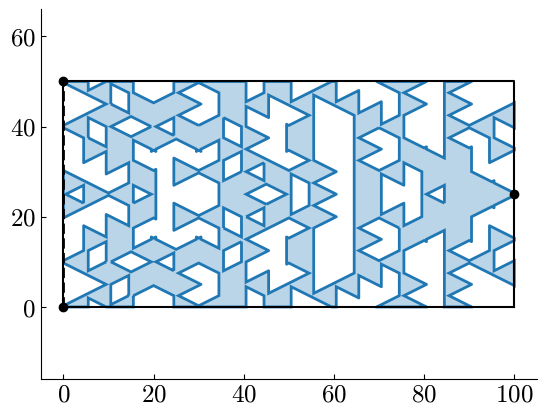

In [35]:
problem.plot_best()

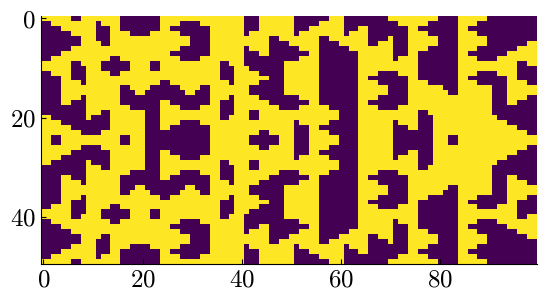

In [36]:
plt.imshow(topology.mask)

In [37]:
from TO.parameterizations.mesh import Delaunay  

parameterization = Delaunay(topology, False, True, n_points=5, mmc_cls=Capsules)

problem = create_horizontal_cantilever_problem(topology, parameterization)
run_experiment(problem, budget=500, sigma0=0.25, seed=1, name='tutorial')

(6_w,12)-aCMA-ES (mu_w=3.7,w_1=40%) in dimension 19 (seed=1, Tue Apr 22 09:11:45 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     12 3.450000000000000e+08 1.0e+00 2.30e-01  2e-01  2e-01 0:00.1
    2     24 2.700000000000000e+08 1.1e+00 2.20e-01  2e-01  2e-01 0:00.1
    3     36 1.727999999999999e+08 1.1e+00 2.16e-01  2e-01  2e-01 0:00.2
   61    732 3.681552991960209e+04 1.9e+00 1.36e-01  1e-01  1e-01 0:03.3
   86   1032 3.203364993778366e-01 2.2e+00 7.63e-02  5e-02  8e-02 0:07.7
  100   1200 2.107949465456811e-01 2.4e+00 8.45e-02  6e-02  1e-01 0:12.5
  115   1380 1.307721371014215e-01 2.5e+00 5.70e-02  4e-02  6e-02 0:19.0
  125   1500 9.290640782388969e-02 2.6e+00 4.91e-02  3e-02  5e-02 0:26.1
  140   1680 1.207759803995422e-01 2.8e+00 4.68e-02  3e-02  5e-02 0:34.5
  154   1848 9.380659364589435e-02 3.3e+00 4.27e-02  3e-02  5e-02 0:44.5
  166   1992 9.133690642839802e-02 3.3e+00 3.84e-02  2e-02  4e-02 0:54.8


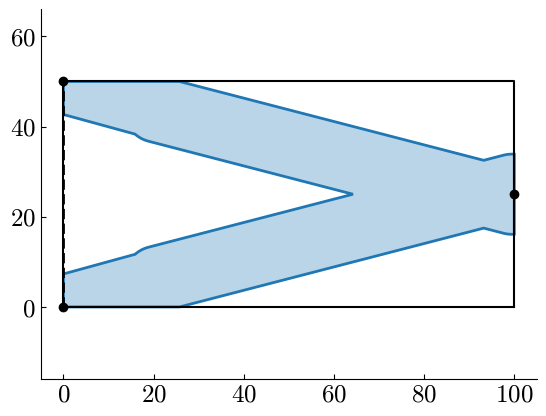

In [38]:
problem.plot_best()

In [39]:
from TO.parameterizations.mesh import Delaunay  

parameterization = Delaunay(topology, False, True, n_points=7, mmc_cls=Capsules)

problem = create_horizontal_cantilever_problem(topology, parameterization)
run_experiment(problem, budget=500, sigma0=0.25, seed=1, name='tutorial')

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 29 (seed=1, Tue Apr 22 09:12:46 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 4.090000000000001e+08 1.0e+00 2.37e-01  2e-01  2e-01 0:00.1
    2     28 4.572000000000001e+08 1.1e+00 2.29e-01  2e-01  2e-01 0:00.3
    3     42 4.818000000000000e+08 1.1e+00 2.27e-01  2e-01  2e-01 0:00.4
   36    504 5.053997034925000e+04 1.7e+00 2.10e-01  2e-01  2e-01 0:03.4
   81   1134 4.781224608341612e+04 2.1e+00 1.39e-01  1e-01  2e-01 0:07.5
  100   1400 4.809621149242225e+04 2.2e+00 9.49e-02  8e-02  1e-01 0:09.2
  151   2114 3.048585373561512e-01 2.5e+00 5.98e-02  5e-02  7e-02 0:16.0
  168   2352 2.403001862793677e-01 2.5e+00 4.83e-02  4e-02  5e-02 0:23.6
  178   2492 2.799278662353613e-01 2.4e+00 3.95e-02  3e-02  4e-02 0:31.7
  189   2646 1.828239871137313e-01 2.5e+00 4.15e-02  3e-02  5e-02 0:41.0
  200   2800 2.038161146797851e-01 2.5e+00 3.65e-02  3e-02  4e-02 0:50.5
  214   2996 1.776806015889211e-01 2.5

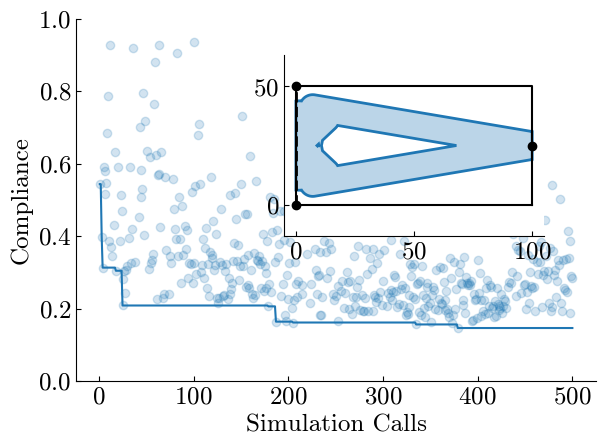

In [40]:
fig, ax = plt.subplots()
ins = ax.inset_axes([0.4,0.4,0.5,0.5])

ax.plot(np.arange(problem.budget)+1, np.minimum.accumulate(problem.scores))
ax.plot(np.arange(problem.budget)+1, problem.scores, 'C0o', alpha=.2)
ax.set_ylim(0, 1); ax.set_xlabel('Simulation Calls'); ax.set_ylabel('Compliance')

problem.plot_best(ins)
fig.tight_layout()